## Import the libraries

In [1]:
import string
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import pickle
from os.path import exists
import time

from keras.applications.xception import Xception
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# library to show the progress of loops.
from tqdm import tqdm
tqdm().pandas()

0it [00:00, ?it/s]


## Get and prepare the textual data

In [2]:
PATH_TO_TEXTS = 'dataset/Flickr8k_text/'
PATH_TO_IMAGES = 'dataset/Flickr8k_Dataset/Flicker8k_Dataset/'
PATH_TO_TRAIN_FILE_NAMES = PATH_TO_TEXTS + 'Flickr_8k.trainImages.txt'
PATH_TO_TEST_FILE_NAMES = PATH_TO_TEXTS + 'Flickr_8k.testImages.txt'

In [3]:
def get_text_from_file(file_path):
    with open(file_path, 'r') as f:
        text = f.read()
    return text

In [4]:
tokens = get_text_from_file(PATH_TO_TEXTS + 'Flickr8k.token.txt')
tokens[0:300]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the s'

In [5]:
tokens[-1]

'\n'

In [6]:
def get_all_descriptions(text):
    descriptions = [line.split('\t')[-1] for line in text.split('\n') if len(line) > 1]
    return descriptions

all_descriptions = get_all_descriptions(tokens)

print(f'Total number of descriptions in all_descriptions: {len(all_descriptions)}')
print('Expected number of descriptions: ' + str(len(tokens.split("\n"))-1))

Total number of descriptions in all_descriptions: 40460
Expected number of descriptions: 40460


In [7]:
all_descriptions[0:7]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .']

In [8]:
def get_all_file_names(text):
    lines = text.split('\n')
    reference = ''
    files = []

    for line in lines:
        file_name = line.split('#')[0]
        if reference != (file_name := line.split('#')[0]) and (len(file_name) > 1):
            files.append(file_name)
            reference = file_name

    return files

all_file_names = get_all_file_names(tokens)

print(f'Number of different file names: {len(all_file_names)}')
# There are 5 descriptions per file
print(f'Expect number of file names: {int(len(all_descriptions)/5)}')

Number of different file names: 8092
Expect number of file names: 8092


In [9]:
def clear_descriptions(descriptions):
    clear_descriptions = []
    table = str.maketrans('','',string.punctuation)

    for description in descriptions:
        description = description.replace('-', '').split(' ')
        description = [word.translate(table) for word in description]
        description = [word.lower() for word in description if (len(word) > 1) and (word.isalpha())]
        description = ' '.join(description)
        clear_descriptions.append(description)

    return clear_descriptions

all_descriptions = clear_descriptions(all_descriptions)
all_descriptions[0:7]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin',
 'black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road']

In [10]:
print(f'len(all_descriptions): {len(all_descriptions)}')

len(all_descriptions): 40460


In [11]:
def get_image_and_descriptions_dictionary(file_names, all_descriptions):
    image_and_descriptions_dict = {}

    for idx, file in enumerate(file_names):
        descriptions = []
        for i in range(5):
            descriptions.append(all_descriptions[i + idx*5])
        
        image_and_descriptions_dict[file] = descriptions
    
    return image_and_descriptions_dict

image_and_descriptions_dict = get_image_and_descriptions_dictionary(all_file_names, all_descriptions)

print(f'len(image_and_descriptions_dict): {len(image_and_descriptions_dict)}')
print(f'len(all_file_names): {len(all_file_names)}')

len(image_and_descriptions_dict): 8092
len(all_file_names): 8092


In [12]:
print(all_file_names[0])
for i in range(5):
    print(all_descriptions[i])

1000268201_693b08cb0e.jpg
child in pink dress is climbing up set of stairs in an entry way
girl going into wooden building
little girl climbing into wooden playhouse
little girl climbing the stairs to her playhouse
little girl in pink dress going into wooden cabin


In [13]:
image_and_descriptions_dict['1000268201_693b08cb0e.jpg']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [14]:
print(all_file_names[-1])
for i in range(-5, 0):
    print(all_descriptions[i])

997722733_0cb5439472.jpg
man in pink shirt climbs rock face
man is rock climbing high in the air
person in red shirt climbing up rock face covered in assist handles
rock climber in red shirt
rock climber practices on rock climbing wall


In [15]:
image_and_descriptions_dict['997722733_0cb5439472.jpg']

['man in pink shirt climbs rock face',
 'man is rock climbing high in the air',
 'person in red shirt climbing up rock face covered in assist handles',
 'rock climber in red shirt',
 'rock climber practices on rock climbing wall']

### Check for inconsistencies in the dataset

In [16]:
def check_missing_files(files_dictionary):
    missing_files = []
    cnt = 0

    for file in files_dictionary:
        if not exists(PATH_TO_IMAGES + file):
            missing_files.append(file)
            cnt += 1
            print(f'File not found: {file}')
    if cnt == 0:
        print('There are no missing files')
        return None
    else:
        print(f'Total missing files: {cnt}')
        return missing_files

In [17]:
missing_files = check_missing_files(image_and_descriptions_dict)

File not found: 2258277193_586949ec62.jpg.1
Total missing files: 1


In [18]:
image_and_descriptions_dict['2258277193_586949ec62.jpg.1']

['people waiting for the subway',
 'some people looking out windows in large building',
 'three people are waiting on train platform',
 'three people standing at station',
 'two woman and one man standing near train tracks']

In [19]:
missing_files

['2258277193_586949ec62.jpg.1']

Drop the dictionary entry of the missing file

In [20]:
for file in missing_files:
    image_and_descriptions_dict.pop(file)

In [21]:
check_missing_files(image_and_descriptions_dict)

There are no missing files


In [22]:
try:
    image_and_descriptions_dict['2258277193_586949ec62.jpg.1']
except:
    print('Dictionary entry removed!')

Dictionary entry removed!


Update the variables

In [23]:
print(f'Lenght of of all_file_names before removing the missing file: {len(all_file_names)}')
all_file_names = [key for key in image_and_descriptions_dict]
print(f'Lenght of of all_file_names after removing the missing file: {len(all_file_names)}')

Lenght of of all_file_names before removing the missing file: 8092
Lenght of of all_file_names after removing the missing file: 8091


In [24]:
print(f'Lenght of of all_descriptions before removing the missing file: {len(all_descriptions)}')
all_descriptions = []
for key in image_and_descriptions_dict:
    for description in image_and_descriptions_dict[key]:
        all_descriptions.append(description)
print(f'Lenght of of all_descriptions after removing the missing file: {len(all_descriptions)}')

Lenght of of all_descriptions before removing the missing file: 40460
Lenght of of all_descriptions after removing the missing file: 40455


### Get the vocabulary

In [25]:
def get_vocabulary(all_descriptions):
    vocabulary = set()
    for description in all_descriptions:
        for word in description.split():
            if len(word) > 1:
                vocabulary.add(word)
    return list(vocabulary)

vocabulary = get_vocabulary(all_descriptions)
print(f'len(vocabulary): {len(vocabulary)}')
vocabulary[0:10]

len(vocabulary): 8763


['diego',
 'out',
 'shrubbery',
 'rockets',
 'notsocrowded',
 'dressed',
 'bounced',
 'tackler',
 'hitting',
 'parasailer']

In [26]:
files_test_raw = get_all_file_names(get_text_from_file(PATH_TO_TEST_FILE_NAMES))
files_test = [file for file in files_test_raw if file not in missing_files]
print(f'len(files_test_raw): {len(files_test_raw)}')
print(f'len(files_test): {len(files_test)}')
files_test[0:3]

len(files_test_raw): 1000
len(files_test): 1000


['3385593926_d3e9c21170.jpg',
 '2677656448_6b7e7702af.jpg',
 '311146855_0b65fdb169.jpg']

In [27]:
files_train_raw = get_all_file_names(get_text_from_file(PATH_TO_TRAIN_FILE_NAMES))
files_train = [file for file in files_train_raw if file not in missing_files]
print(f'len(files_train_raw): {len(files_train_raw)}')
print(f'len(files_train): {len(files_train)}')
files_train[0:3]

len(files_train_raw): 6000
len(files_train): 6000


['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg']

## Extract features using Xception model

In [28]:
def xception_features(img_files):
        model = Xception(include_top=False, pooling='avg')
        features = {}
        
        for img in tqdm(img_files):
            file_path = PATH_TO_IMAGES + img
            image = Image.open(file_path)
        
            # Adjust the image to fit in the pre-trained model
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            image = image/127.5
            image = image - 1.0
        
            feature = model.predict(image)
            features[img] = feature
        return features

Dont run the cell below. It takes 40 minutes to run.


Instead, use the features.pkl object

In [29]:
# features = xception_features(all_file_names)

### Save/Load the features

In [30]:
# with open('features.pkl', 'wb') as f:
#     pickle.dump(features, f)

In [31]:
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

### Prepare training data

In [32]:
train_dict = {key: image_and_descriptions_dict[key] for key in files_train}
all_train_descriptions = []
for key in train_dict:
    key_descriptions = []
    for description in train_dict[key]:
        description = 'start_description ' + description + ' end_description'
        all_train_descriptions.append(description)
        key_descriptions.append(description)
    train_dict[key] = key_descriptions

In [33]:
all_train_descriptions[0]

'start_description black dog is running after white dog in the snow end_description'

In [34]:
train_features = {key: features[key] for key in files_train}

In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_train_descriptions)

### Get the maximum length of the descriptions

In [36]:
vocabulary_lenght = len(tokenizer.word_index) + 1
print(f'vocabulary_lenght: {vocabulary_lenght}')

vocabulary_lenght: 7578


In [37]:
descriptions_max_length = 0
for description in all_descriptions:
    if len(description.split()) > descriptions_max_length:
        descriptions_max_length = len(description.split())

print(f"descriptions_max_length: {descriptions_max_length}")

descriptions_max_length: 32


In [38]:
test_descriptions = [image_and_descriptions_dict[key] for key in files_test]

In [39]:
test_descriptions[0:3]

[['the dogs are in the snow in front of fence',
  'the dogs play on the snow',
  'two brown dogs playfully fight in the snow',
  'two brown dogs wrestle in the snow',
  'two dogs playing in the snow'],
 ['brown and white dog swimming towards some in the pool',
  'dog in swimming pool swims toward sombody we cannot see',
  'dog swims in pool near person',
  'small dog is paddling through the water in pool',
  'the small brown and white dog is in the pool'],
 ['man and woman in festive costumes dancing',
  'man and woman with feathers on her head dance',
  'man and woman wearing decorative costumes and dancing in crowd of onlookers',
  'one performer wearing feathered headdress dancing with another performer in the streets',
  'two people are dancing with drums on the right and crowd behind them']]

### Data Generator

In [40]:
def data_generator(image_and_descriptions_dict, features, tokenizer, descriptions_max_length):
    while True:
        for image, descriptions in image_and_descriptions_dict.items():
            feature = features[image][0]
            input_image, input_sequence, output_word = get_sequency(tokenizer, descriptions_max_length, descriptions, feature)
            
            yield [[input_image, input_sequence], output_word]         


def get_sequency(tokenizer, descriptions_max_length, descriptions, feature):
    features = [] 
    input_sequeces = []
    output_sequences = []

    for description in descriptions:
        tokens = tokenizer.texts_to_sequences([description])[0]
        for i in range(1, len(tokens)):
            input_sequence = tokens[:i]
            # pad input sequence (fills the input_sequence with 0 on the left until descriptions_max_length)
            input_sequence = pad_sequences([input_sequence], maxlen=descriptions_max_length)[0]

            output_sequence = tokens[i]
            output_sequence = to_categorical([output_sequence], num_classes=vocabulary_lenght)[0]

            features.append(feature)
            input_sequeces.append(input_sequence)
            output_sequences.append(output_sequence)
    
    return np.array(features), np.array(input_sequeces), np.array(output_sequences)

In [41]:
[features_test, input_sequeces_test], output_sequences = next(data_generator(image_and_descriptions_dict, features, tokenizer, descriptions_max_length))
print(f'features_test shape: {features_test.shape}')
print(f'input_sequeces_test shape: {input_sequeces_test.shape}')
print(f'output_sequences shape: {output_sequences.shape}')

features_test shape: (37, 2048)
input_sequeces_test shape: (37, 32)
output_sequences shape: (37, 7578)


In [42]:
# from keras.utils import plot_model

# # define the captioning model
# def define_model(vocab_size, max_length):

#     # features from the CNN model squeezed from 2048 to 256 nodes
#     inputs1 = Input(shape=(2048,))
#     fe1 = Dropout(0.5)(inputs1)
#     fe2 = Dense(256, activation='relu')(fe1)

#     # LSTM sequence model
#     inputs2 = Input(shape=(max_length,))
#     se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
#     se2 = Dropout(0.5)(se1)
#     se3 = LSTM(256)(se2)

#     # Merging both models
#     decoder1 = add([fe2, se3])
#     decoder2 = Dense(256, activation='relu')(decoder1)
#     outputs = Dense(vocab_size, activation='softmax')(decoder2)

#     # tie it together [image, seq] [word]
#     model = Model(inputs=[inputs1, inputs2], outputs=outputs)
#     model.compile(loss='categorical_crossentropy', optimizer='adam')

#     # summarize model
#     print(model.summary())
#     plot_model(model, to_file='model.png', show_shapes=True)

#     return model

In [43]:
# features from Xception (CNN model)
input_features_xception = Input(shape=(2048,))
hidden_layer_xception_1 = Dense(256, activation='relu')(input_features_xception)
hidden_layer_xception_2 = Dropout(0.4)(hidden_layer_xception_1)
hidden_layer_xception_3 = Dense(128, activation='relu')(hidden_layer_xception_2)
hidden_layer_xception_4 = Dropout(0.2)(hidden_layer_xception_3)

# LSTM sequence model
input_features_lstm = Input(shape=(descriptions_max_length,))
hidden_layer_lstm_1 = Embedding(vocabulary_lenght, 256, mask_zero=True)(input_features_lstm)
hidden_layer_lstm_2 = Dropout(0.5)(hidden_layer_lstm_1)
hidden_layer_lstm_3 = LSTM(128)(hidden_layer_lstm_2)

# Merging both models
merging_layer = add([hidden_layer_xception_4, hidden_layer_lstm_3])
merged_model_hidden_1 = Dense(128, activation='relu')(merging_layer)
output_layer = Dense(vocabulary_lenght, activation='softmax')(merged_model_hidden_1)

# tie it together [image, seq] [word]
model = Model(inputs=[input_features_xception, input_features_lstm], outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 dropout (Dropout)              (None, 256)          0           ['dense[0][0]']                  
                                                                                              

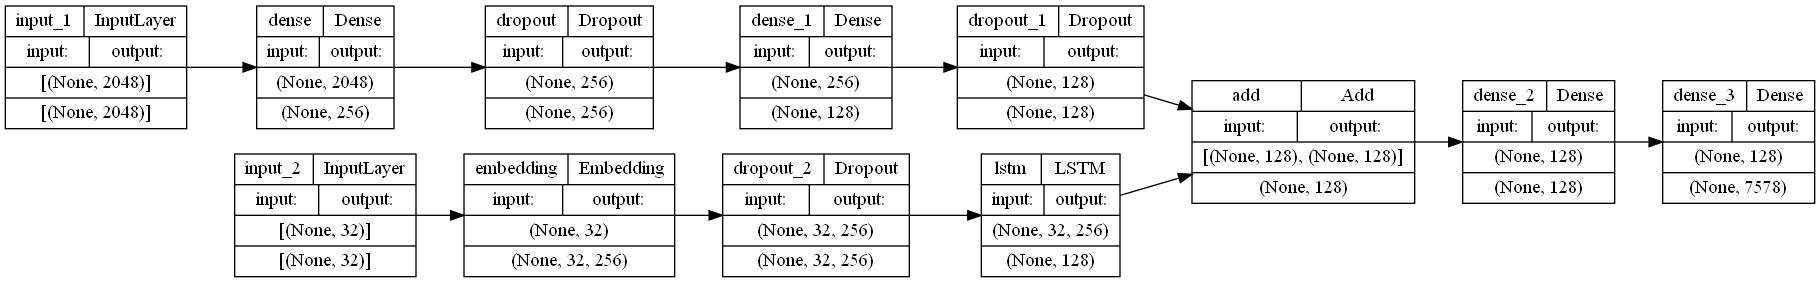

In [45]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR')

Don't run it.

It thakes several hours (9+) to run.

Instead, load the model.

In [46]:
# training_config = [{'learning_rate': 0.001, 'epochs': 25}, 
#                    {'learning_rate': 0.0001, 'epochs': 5}]

# steps = len(train_dict)
# aux_cnt = 0

# for config in training_config:
#     epochs = config['epochs']
#     model.optimizer.learning_rate = config['learning_rate'] 

#     for epoch in range(epochs):
#         data = data_generator(train_dict, train_features, tokenizer, descriptions_max_length)
#         model.fit(data, epochs=1, steps_per_epoch=steps, verbose=1)
#         aux_cnt += 1
#         model.save("saved_models/model_" + str(aux_cnt) + ".h5")
#         # Give my laptop a deserved break
#         time.sleep(60*4)

6000/6000 [==============================] - 1390s 232ms/step - loss: 2.3855


In [48]:
model = load_model('saved_models/model_30.h5')

In [61]:
def extract_features(filename, model):
        image = Image.open(filename)
        image = image.resize((299,299))
        image = np.array(image)
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature


def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break
    
    return in_text


def get_prediction(file):
    img_path = PATH_TO_IMAGES + file
    xception_model = Xception(include_top=False, pooling="avg")

    photo = extract_features(img_path, xception_model)

    description = generate_desc(model, tokenizer, photo, descriptions_max_length)
    description = description[18:-3]
    
    return description

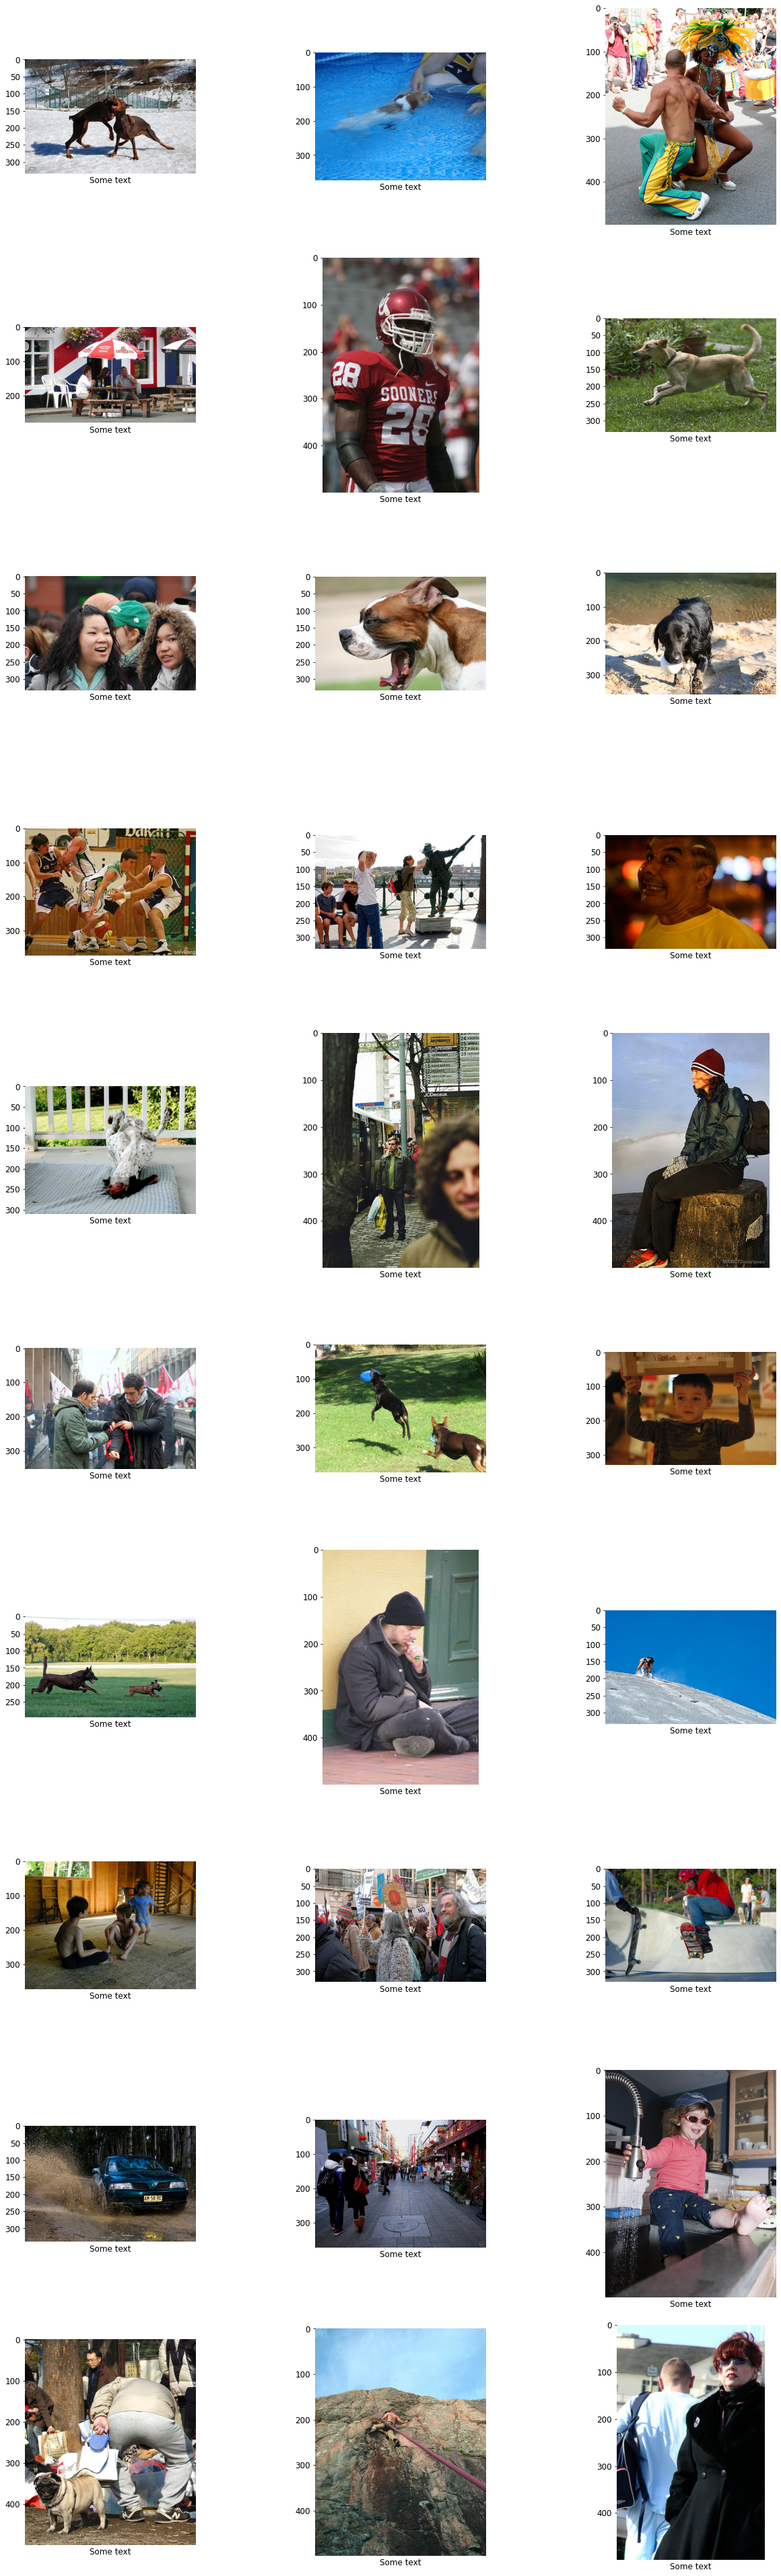

In [116]:
plt.figure(figsize=(20, 70))
plt.rc('font', size=12)

for i in range(30):
    plt.subplot(10, 3, i+1, frameon=False)
    plt.subplots_adjust(wspace=0.7, hspace=0.1)
    plt.xticks([])

    img_path = PATH_TO_IMAGES + files_test[i]
    img = Image.open(img_path)
    
    # plt.xlabel(get_prediction(files_test[i]))
    plt.xlabel('Some text')
    plt.imshow(img)

plt.show()